# Synthetic Test Case 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
import torch
import pickle
import math
import prior.CustomDistribution as custom
import config
import time
import IPython.display as IPd

from forward import Forward
from survey import Survey

from util import *
from block_utils import *
from pygimli_utils import *

# SimPEG imports
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh

# SBI imports
from sbi.inference import SNPE, SNLE, prepare_for_sbi, simulate_for_sbi, likelihood_estimator_based_potential, \
    MCMCPosterior
from sbi import utils as utils
from sbi.utils import RestrictionEstimator
from sbi.utils import user_input_checks as uic
from sbi import analysis as analysis
from sbi.analysis import check_sbc, run_sbc, get_nltp, sbc_rank_plot

from torch.distributions import Distribution, Uniform, Normal

from svgutils.compose import *

_ = torch.manual_seed(0)

2024-08-06 15:47:46.545102: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 15:47:46.586017: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 15:47:46.586057: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 15:47:46.586081: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 15:47:46.595143: I tensorflow/core/platform/cpu_feature_g

In [2]:
max_depth = 23.5
step_size = 0.5
num_points = int(max_depth / step_size) + 1
max_resistivity = 1000
min_resistivity = 1
num_measurements = 23
num_dim = 48

depths = np.linspace(0, max_depth, num=num_dim)
thicknesses = torch.ones(num_dim) * 0.5

In [3]:
# Survey Setup and Forward Model Setup

survey, electrode_spacing = Survey(num_measurements, min_ab_distance=2, max_ab_distance=100).schlumberger_survey()
forward = Forward(thicknesses, survey)

## Load all posterior models

In [4]:
# **** Step prior
filename_step_model = "pickled_objects/steps_100k_1000_ohm_48points_new.pkl"
inference_step, posterior_step = unpickle_objects(filename_step_model)

# **** Polynomial Prior
filename_legendre_model = "pickled_objects/legendre_100k_1000_ohm_48points_new.pkl"
inference_poly, posterior_poly = unpickle_objects(filename_legendre_model)

# **** Independent Step Prior
filename_ind_steps_model = "pickled_objects/ind_steps_500k_1000_ohm_48points.pkl"
inference_ind_step, posterior_ind_step = unpickle_objects(filename_ind_steps_model)

# **** Block Prior 
filename_block_model = "pickled_objects/block_100k_1000_ohm_48points.pkl"
inference_block, posterior_block = unpickle_objects(filename_block_model)

### Step Model and Functions

In [5]:
# Helper functions for the Step Model 

def steps_forward_model_no_noise(res):
    return forward.dc_forward_model(res)


def steps_forward_model_base_noise_5(res):
    if (np.any([res < 0])):
        nan_array = np.empty((num_measurements,))
        nan_array[:] = np.nan
        return nan_array
    return forward.dc_forward_model_base_noise(res, 5)


# Prior Setup
prior_high_res = max_resistivity
prior_low_res = min_resistivity
custom_prior = custom.CustomDistribution(low=prior_low_res, high=prior_high_res, dimension=num_dim)
prior_step, *_ = uic.process_prior(custom_prior,
                                   custom_prior_wrapper_kwargs=dict(
                                       lower_bound=torch.tensor([custom_prior.low] * custom_prior.dimension),
                                       upper_bound=torch.tensor([custom_prior.high] * custom_prior.dimension)
                                   )
                                   )


/opt/bwhpc/common/jupyter/tensorflow/2023-10-10/lib/python3.9/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'prior.CustomDistribution.CustomDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [6]:
def compute_cis_and_means_from_step_posterior_sammples(observation):
    posterior_sample_size = 100_000
    simulation_sample_size = 1_000
    percentiles = config.percentiles

    # Sample from Step posterior
    posterior_samples_step = posterior_step.sample((posterior_sample_size,), x=observation, show_progress_bars=True)

    # Get random samples form the posterior samples
    perm = torch.randperm(posterior_sample_size)
    idx = perm[:simulation_sample_size]
    random_post_samples = posterior_samples_step[idx]

    # Simulate the Apparent Resistivity from the samples
    sim_apparent_resistivities = []
    for sample in random_post_samples:
        app_res = steps_forward_model_base_noise_5(np.array(sample))
        sim_apparent_resistivities.append(app_res)

    # Compute confidence intervals and mean for resistivity depth profile
    conf_intervals_res = np.nanpercentile(random_post_samples, q=percentiles, axis=0)
    mean_res = np.nanmean(random_post_samples, axis=0)

    # Compute confidence intervals and mean in observation space
    conf_intervals_ar = np.nanpercentile(sim_apparent_resistivities, q=percentiles, axis=0)
    mean_ar = np.nanmean(sim_apparent_resistivities, axis=0)

    return random_post_samples, sim_apparent_resistivities, mean_res, conf_intervals_res, mean_ar, conf_intervals_ar

### Independent Step Model Functions

In [7]:
def compute_cis_and_means_from_ind_step_posterior_sammples(observation):
    posterior_sample_size = 100_000
    simulation_sample_size = 1_000
    percentiles = config.percentiles

    # Sample from Step posterior
    posterior_samples_step = posterior_ind_step.sample((posterior_sample_size,), x=observation, show_progress_bars=True)

    # Get random samples form the posterior samples
    perm = torch.randperm(posterior_sample_size)
    idx = perm[:simulation_sample_size]
    random_post_samples = posterior_samples_step[idx]

    # Simulate the Apparent Resistivity from the samples
    sim_apparent_resistivities = []
    for sample in random_post_samples:
        app_res = steps_forward_model_base_noise_5(np.array(sample))
        sim_apparent_resistivities.append(app_res)

    # Compute confidence intervals and mean for resistivity depth profile
    conf_intervals_res = np.nanpercentile(random_post_samples, q=percentiles, axis=0)
    mean_res = np.nanmean(random_post_samples, axis=0)

    # Compute confidence intervals and mean in observation space
    conf_intervals_ar = np.nanpercentile(sim_apparent_resistivities, q=percentiles, axis=0)
    mean_ar = np.nanmean(sim_apparent_resistivities, axis=0)

    return random_post_samples, sim_apparent_resistivities, mean_res, conf_intervals_res, mean_ar, conf_intervals_ar

### Block Model Functions

In [8]:
n_blocks = 4
res_prior_min = torch.as_tensor([min_resistivity] * n_blocks)
res_prior_max = torch.as_tensor([max_resistivity] * n_blocks)

n_thickness = 3
min_thickness = 0.1
max_thickness = 20.
thickness_prior_min = torch.as_tensor([min_thickness] * n_thickness)
thickness_prior_max = torch.as_tensor([max_thickness] * n_thickness)

prior_min = torch.cat([res_prior_min, thickness_prior_min])
prior_max = torch.cat([res_prior_max, thickness_prior_max])

prior_block = utils.BoxUniform(low=prior_min, high=prior_max)

In [9]:
def dc_forward_block_noise(res_n_depth):
    '''
    Simulator used for generating the training set (noise level 5 \Omega m)
    returns the apparent resistiviy values from  a block sample. 
    '''
    resistivities, thicknesses = split_params(res_n_depth)
    forward = Forward(thicknesses, survey)

    return forward.dc_forward_model_base_noise(resistivities, 5)


def compute_cis_and_means_from_block_posterior_sammples(observation):
    posterior_sample_size = 100_000
    simulation_sample_size = 1_000
    percentiles = config.percentiles

    # Sample from Step posterior
    posterior_samples_step = posterior_block.sample((posterior_sample_size,), x=observation, show_progress_bars=True)

    # Get random samples form the posterior samples
    perm = torch.randperm(posterior_sample_size)
    idx = perm[:simulation_sample_size]
    random_post_samples = posterior_samples_step[idx]

    inv_res_thick_depth, max_depth = transfrom_and_find_max_reached_depth(random_post_samples)
    trans_res_samples = map_resistivities_to_depth(inv_res_thick_depth, max_depth)

    # Simulate the Apparent Resistivity from the samples
    sim_apparent_resistivities = []
    for sample in random_post_samples:
        app_res = dc_forward_block_noise(np.array(sample))
        sim_apparent_resistivities.append(app_res)

    # Compute confidence intervals and mean for resistivity depth profile
    conf_intervals_res = np.nanpercentile(trans_res_samples, q=percentiles, axis=0)
    mean_res = np.nanmean(trans_res_samples, axis=0)

    # Compute confidence intervals and mean in observation space
    conf_intervals_ar = np.nanpercentile(sim_apparent_resistivities, q=percentiles, axis=0)
    mean_ar = np.nanmean(sim_apparent_resistivities, axis=0)

    return random_post_samples, trans_res_samples, sim_apparent_resistivities, mean_res, conf_intervals_res, mean_ar, conf_intervals_ar

### Polynomial Model and Functions

In [10]:
# Helper functions for the Polynomial Model

def normalize(depths, max_depth):
    half_max_depth = max_depth / 2
    return (depths - half_max_depth) / half_max_depth


normalized_depth = normalize(depths, max_depth)


# Legendre Polynomial function
def legendre_polynomial(x, coefficients):
    poly = np.polynomial.legendre.Legendre(coefficients)
    return poly(x)


def legendre_polynomial_nan(coefficients):
    coefficients = coefficients
    poly = legendre_polynomial(normalized_depth, coefficients)
    if np.any((poly < -1) | (poly > 1)):
        return np.full((normalized_depth.shape[0],), np.nan)
    else:
        return poly


def poly_to_resistivity(poly):
    return (poly + 1) * (max_resistivity / 2)


def coefficients_to_resistivity(coeff):
    poly = legendre_polynomial_nan(coeff)
    if np.isnan(poly).all():
        return np.full((num_dim,), np.nan)
    else:
        return poly_to_resistivity(poly)


def legendre_forward_nan(coefficients):
    poly = legendre_polynomial(normalized_depth, coefficients)
    if np.any((poly < -1) | (poly > 1)):
        return np.full((num_measurements,), np.nan)
    else:
        # Shift from [-1,1] interval to [0,2]
        # Then multiply by max_resistivity/2 value to cover the resistivity value range [0, max_resistivity]
        res = poly_to_resistivity(poly)
        return forward.dc_forward_model(res)


# Interpolate Legendre polynomial coefficients and remove invalid simulations by substitue with nan values
def legendre_forward_nan_noise_5(coefficients):
    poly = legendre_polynomial(normalized_depth, coefficients)
    if np.any((poly < -1) | (poly > 1)):
        return np.full((num_measurements,), np.nan)
    else:
        # Shift from [-1,1] interval to [0,2]
        # Then multiply by max_resistivity/2 value to cover the resistivity value range [0, max_resistivity]
        res = poly_to_resistivity(poly)
        return forward.dc_forward_model_base_noise(res, 5)


# Prior Setup 
num_dim_prior = 5
prior_min = torch.as_tensor([-1] * num_dim_prior)
prior_max = torch.as_tensor([1] * num_dim_prior)
prior_poly = utils.BoxUniform(low=prior_min * torch.ones(num_dim_prior), high=prior_max * torch.ones(num_dim_prior))


In [11]:
def compute_cis_and_means_from_poly_posterior_sammples(observation):
    posterior_sample_size = 1_000_000
    simulation_sample_size = 10_000
    percentiles = config.percentiles

    # Sample from Step posterior
    posterior_samples_poly = posterior_poly.sample((posterior_sample_size,), x=observation, show_progress_bars=True)

    # Get random samples form the posterior samples
    perm = torch.randperm(posterior_sample_size)
    idx = perm[:simulation_sample_size]
    random_post_samples = posterior_samples_poly[idx]

    # Simulate the Apparent Resistivity from the samples
    post_resistivities = []
    sim_apparent_resistivities = []
    for sample in random_post_samples:
        post_resistivities.append(coefficients_to_resistivity(sample))
        app_res = legendre_forward_nan_noise_5(np.array(sample))
        sim_apparent_resistivities.append(app_res)

    # Compute confidence intervals for resistivity and the simulated apparent_resistivity
    conf_intervals_res = np.nanpercentile(post_resistivities, q=percentiles, axis=0)
    mean_res = np.nanmean(post_resistivities, axis=0)

    conf_intervals_ar = np.nanpercentile(sim_apparent_resistivities, q=percentiles, axis=0)
    mean_ar = np.nanmean(sim_apparent_resistivities, axis=0)

    return post_resistivities, sim_apparent_resistivities, mean_res, conf_intervals_res, mean_ar, conf_intervals_ar

# Load or generate Synthtetic Test Data

#### Step

In [12]:
# Define prior for the inference problem of the coefficients of the Legendre Polynomial
prior_high_res = max_resistivity
prior_low_res = 1
custom_prior = custom.CustomDistribution(low=prior_low_res, high=prior_high_res, dimension=num_dim)
prior_step, *_ = uic.process_prior(custom_prior,
                                   custom_prior_wrapper_kwargs=dict(
                                       lower_bound=torch.tensor([custom_prior.low] * custom_prior.dimension),
                                       upper_bound=torch.tensor([custom_prior.high] * custom_prior.dimension)
                                   )
                                   )


In [13]:
load_sample = True
filename_synth_step = 'pickled_objects/synthetic_samples/step_simulation_prior_sample_48.pkl'
if load_sample:
    prior_sample_step, app_res_step = unpickle_objects(filename_synth_step)
else:
    prior_sample_step = prior_step.sample((1,))[0]
    app_res_step = steps_forward_model_base_noise_5(prior_sample_step)
    pickle_objects([prior_sample_step, app_res_step], filename=filename_synth_step)

#### Polynomial

In [14]:
num_dim_poly = 5
prior_min = torch.as_tensor([-1] * num_dim_poly)
prior_max = torch.as_tensor([1] * num_dim_poly)
poly_prior = utils.BoxUniform(low=prior_min * torch.ones(num_dim_poly), high=prior_max * torch.ones(num_dim_poly))

In [15]:
load_sample = True
filename_synth_poly = 'pickled_objects/synthetic_samples/polynom_simulation_prior_sample_48.pkl'
if load_sample:
    prior_sample_poly, app_res_poly = unpickle_objects(filename_synth_poly)
else:
    valid_sample = False
    while not valid_sample:
        prior_sample_poly = poly_prior.sample((1,))[0]
        poly_depth = legendre_polynomial_nan(prior_sample_poly)
        if not np.isnan(poly_depth).all():
            app_res_poly = torch.tensor(legendre_forward_nan(prior_sample_poly))
            valid_sample = True

    pickle_objects([prior_sample_poly, app_res_poly], filename=filename_synth_poly)

#### Block

In [16]:
load_sample = True
filename_synth_block = 'pickled_objects/synthetic_samples/block_simulation_sample.pkl'
if load_sample:
    resistivites_block, app_res_block = unpickle_objects(filename_synth_block)
else:
    resistivites_block = torch.cat((torch.linspace(350, 350, 4), torch.linspace(400, 400, 10),
                                    torch.linspace(200, 200, 20), torch.linspace(100, 100, 14)), dim=0)
    app_res_block = forward.dc_forward_model(resistivites_block)
    pickle_objects([resistivites_block, app_res_block], filename=filename_synth_block)

# Validation of Step Posterior on Synthetic Data

In [17]:
posterior_sample_size = 100_000
simulation_sample_size = 1_000

### Validation on Step Example

In [18]:
random_post_samples_step, sim_apparent_resistivities_step, mean_res_step, conf_intervals_res_step, mean_ar_step, conf_intervals_ar_step = compute_cis_and_means_from_step_posterior_sammples(
    app_res_step)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [19]:
print('Avg RMSE parameter space:', avg_rmse(prior_sample_step, random_post_samples_step))
print('Avg RMSE parameter space:', avg_rmse(app_res_step, sim_apparent_resistivities_step))

Avg RMSE parameter space: 70.40272
Avg RMSE parameter space: 4.1811924186806815


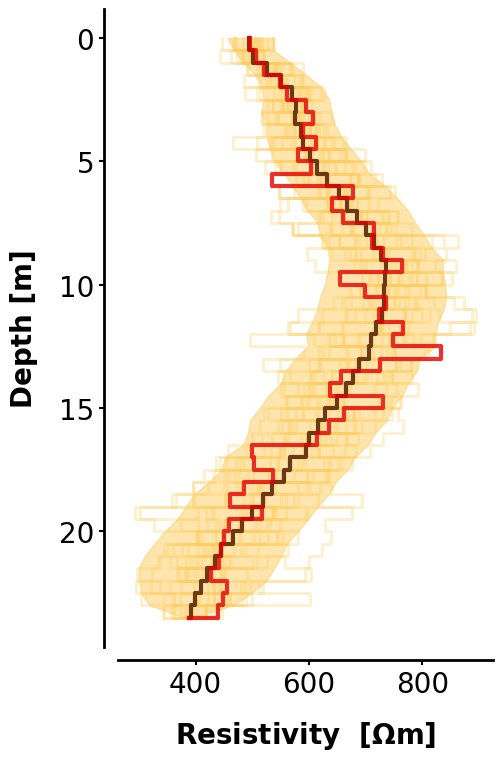

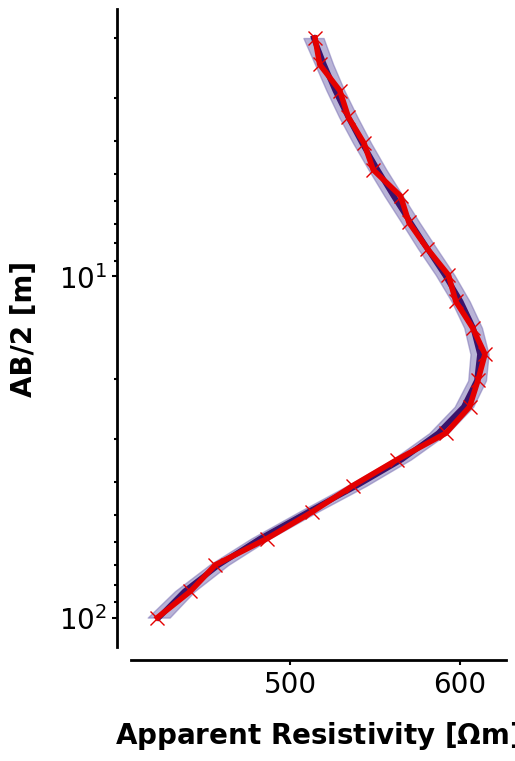

In [20]:
plot_depth_profile_with_ci(
    res_samples=random_post_samples_step,
    gt_res=prior_sample_step,
    mean_res=mean_res_step,
    conf_intervals_res=conf_intervals_res_step,
    filename='synth_data/ppc_step_posterior_on_simulated_data_step_depth.svg',
    step=True,
    mean_step=True,
    yaxis_label=True,
)

plot_app_res_with_ci(
    app_res_samples=None,  #sim_apparent_resistivities_step,
    gt_app_res=app_res_step,
    mean_app_res=mean_ar_step,
    conf_intervals_app_res=conf_intervals_ar_step,
    filename='synth_data/ppc_step_posterior_on_simulated_data_step_app_res.svg',
    yaxis_label=True
)


### Validation on Polynomial Example

In [21]:
post_resistivities_poly, sim_apparent_resistivities_poly, mean_res_poly, conf_intervals_res_poly, mean_ar_poly, conf_intervals_ar_poly = compute_cis_and_means_from_step_posterior_sammples(
    app_res_poly)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [22]:
print('Avg RMSE parameter space:', avg_rmse(coefficients_to_resistivity(prior_sample_poly), post_resistivities_poly))
print('Avg RMSE parameter space:', avg_rmse(app_res_poly, sim_apparent_resistivities_poly))

Avg RMSE parameter space: 85.39944844261454
Avg RMSE parameter space: 4.034490387609388


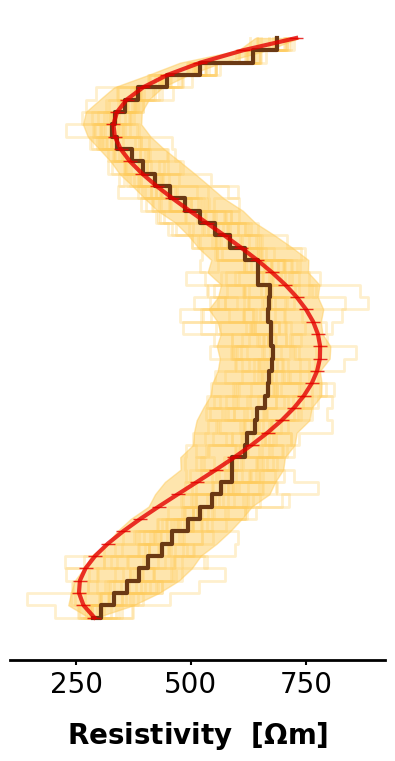

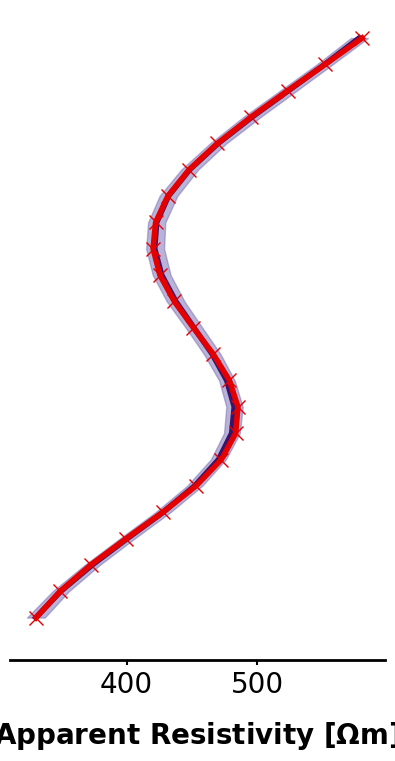

In [23]:
plot_depth_profile_with_ci(
    res_samples=post_resistivities_poly,
    gt_res=coefficients_to_resistivity(prior_sample_poly),
    mean_res=mean_res_poly,
    conf_intervals_res=conf_intervals_res_poly,
    filename='synth_data/ppc_step_posterior_on_simulated_data_poly_depth.svg',
    step=False,
    mean_step=True,
    yaxis_visible=False
)

plot_app_res_with_ci(
    app_res_samples=None,  #sim_apparent_resistivities_poly,
    gt_app_res=app_res_poly,
    mean_app_res=mean_ar_poly,
    conf_intervals_app_res=conf_intervals_ar_poly,
    filename='synth_data/ppc_step_posterior_on_simulated_data_poly_app_res.svg',
    legend=False,
    yaxis_visible=False
)


### Validation on Block Example

In [24]:
random_post_samples_block, sim_apparent_resistivities_block, mean_res_block, conf_intervals_res_block, mean_ar_block, conf_intervals_ar_block = compute_cis_and_means_from_step_posterior_sammples(
    app_res_block)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [25]:
print('Avg RMSE parameter space:', avg_rmse(resistivites_block, random_post_samples_block))
print('Avg RMSE parameter space:', avg_rmse(app_res_block, sim_apparent_resistivities_block))

Avg RMSE parameter space: 65.22763
Avg RMSE parameter space: 6.477390817541571


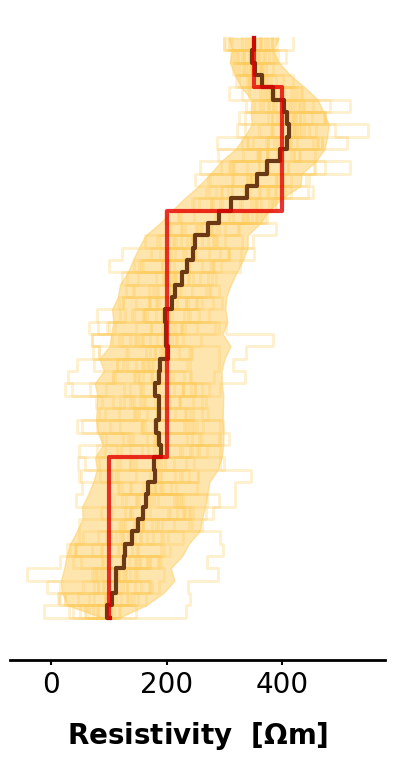

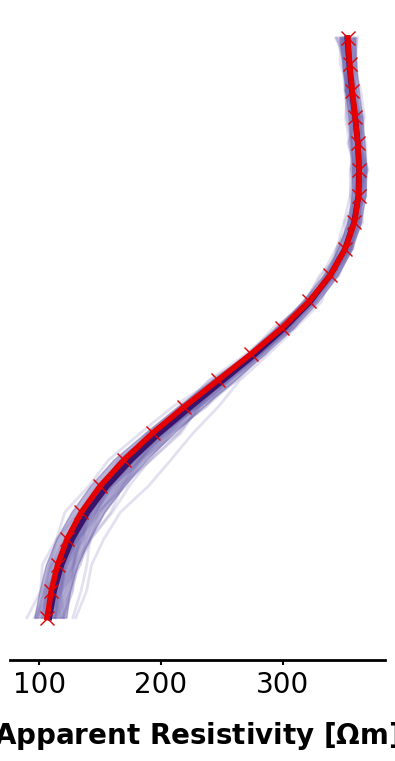

In [26]:
plot_depth_profile_with_ci(
    res_samples=random_post_samples_block,
    gt_res=resistivites_block,
    mean_res=mean_res_block,
    conf_intervals_res=conf_intervals_res_block,
    filename='synth_data/ppc_step_posterior_on_simulated_data_block_depth.svg',
    step=True,
    mean_step=True,
    yaxis_visible=False
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_block,
    gt_app_res=app_res_block,
    mean_app_res=mean_ar_block,
    conf_intervals_app_res=conf_intervals_ar_block,
    filename='synth_data/ppc_step_posterior_on_simulated_data_block_app_res.svg',
    yaxis_label=True,
    yaxis_visible=False
)


### Merge Plots to one figure

In [28]:
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '14pt', 'weight': '800'}
kwargs_text_light = {'size': '10pt', 'weight': '600'}

f = Figure("50cm", "40cm",

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_block_depth.svg").scale(svg_scale),
               Text("c", -20, 50, **kwargs_text)
           ).move(940, 20),

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_block_app_res.svg").scale(svg_scale),
               Text("f", -20, 50, **kwargs_text)
           ).move(940, 720),

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_step_app_res.svg").scale(svg_scale),
               Text("d", -20, 50, **kwargs_text)
           ).move(40, 720),

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_poly_app_res.svg").scale(svg_scale),
               Text("e", -20, 50, **kwargs_text)
           ).move(530, 720),

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_step_depth.svg").scale(svg_scale),
               Text("a", -10, 50, **kwargs_text)
           ).move(40, 20),

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_poly_depth.svg").scale(svg_scale),
               Text("b", -20, 50, **kwargs_text)
           ).move(530, 20),
           )

f.save("plots/figures/fig2/synth_data_step_posterior_new_colors.svg")
svg("plots/figures/fig2/synth_data_step_posterior_new_colors.svg")

# Validation of Polynomial Posterior on Synthetic Data

### Validation on Step Example

In [29]:
random_post_samples_step, sim_apparent_resistivities_step, mean_res_step, conf_intervals_res_step, mean_ar_step, conf_intervals_ar_step = compute_cis_and_means_from_poly_posterior_sammples(
    app_res_step)

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [30]:
print('Avg RMSE parameter space:', avg_rmse(prior_sample_step, random_post_samples_step))
print('Avg RMSE parameter space:', avg_rmse(app_res_step, sim_apparent_resistivities_step))

Avg RMSE parameter space: 46.15415883068984
Avg RMSE parameter space: 4.14871492442673


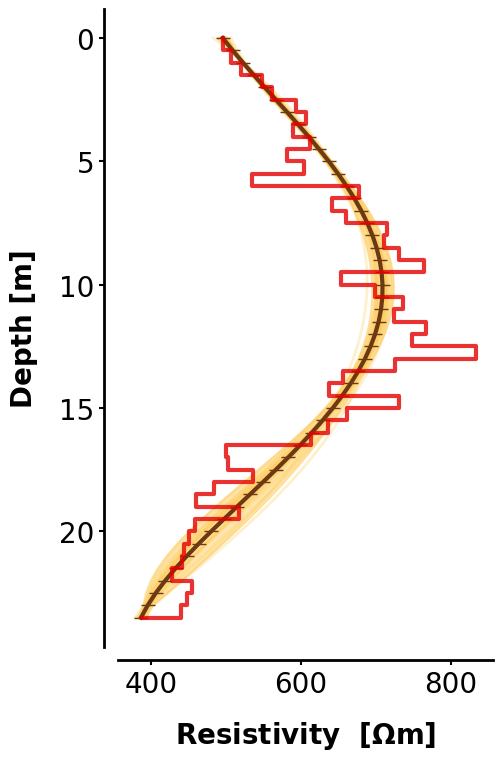

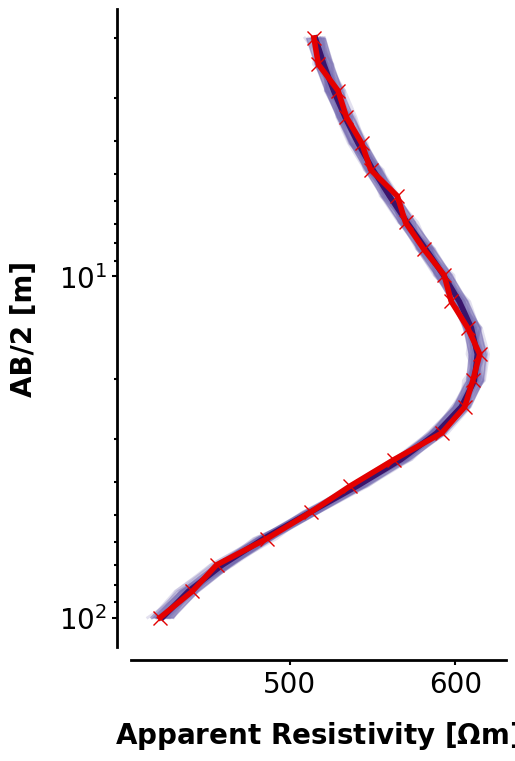

In [31]:
plot_depth_profile_with_ci(
    res_samples=random_post_samples_step,
    gt_res=prior_sample_step,
    mean_res=mean_res_step,
    conf_intervals_res=conf_intervals_res_step,
    filename='synth_data/ppc_poly_posterior_on_simulated_data_step_depth.svg',
    step=True,
    mean_step=False,
    yaxis_label=True,
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_step,
    gt_app_res=app_res_step,
    mean_app_res=mean_ar_step,
    conf_intervals_app_res=conf_intervals_ar_step,
    filename='synth_data/ppc_poly_posterior_on_simulated_data_step_app_res.svg',
    yaxis_label=True
)


### Validation on Polynomial Example

In [32]:
post_resistivities_poly, sim_apparent_resistivities_poly, mean_res_poly, conf_intervals_res_poly, mean_ar_poly, conf_intervals_ar_poly = compute_cis_and_means_from_poly_posterior_sammples(
    app_res_poly)

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [33]:
print('Avg RMSE parameter space:', avg_rmse(coefficients_to_resistivity(prior_sample_poly), post_resistivities_poly))
print('Avg RMSE parameter space:', avg_rmse(app_res_poly, sim_apparent_resistivities_poly))

Avg RMSE parameter space: 8.216612558620788
Avg RMSE parameter space: 3.31340463576692


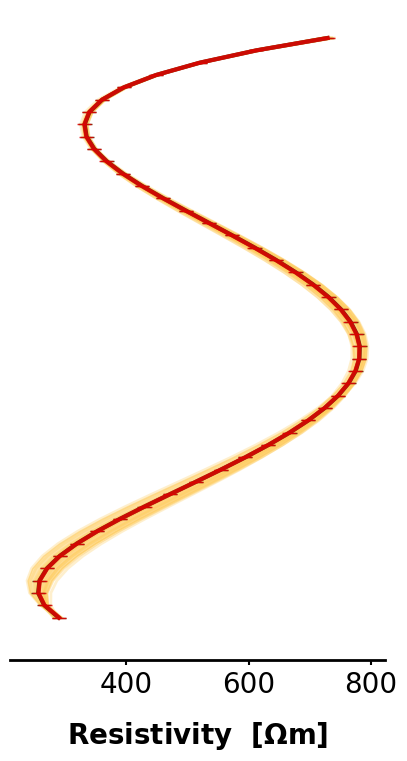

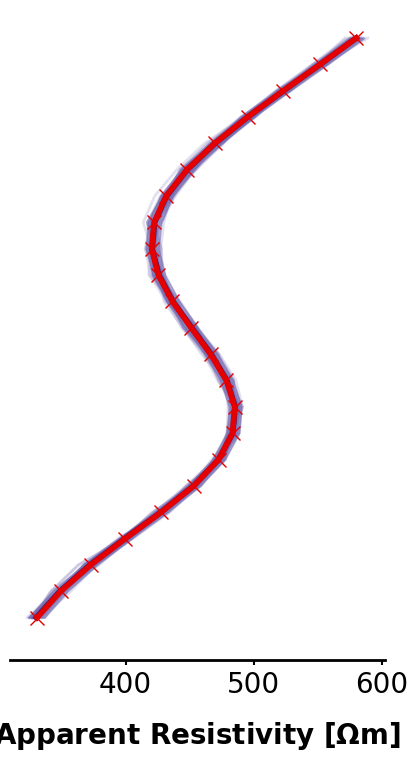

In [34]:
plot_depth_profile_with_ci(
    res_samples=post_resistivities_poly,
    gt_res=coefficients_to_resistivity(prior_sample_poly),
    mean_res=mean_res_poly,
    conf_intervals_res=conf_intervals_res_poly,
    filename='synth_data/ppc_poly_posterior_on_simulated_data_poly_depth.svg',
    step=False,
    mean_step=False,
    yaxis_visible=False
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_poly,
    gt_app_res=app_res_poly,
    mean_app_res=mean_ar_poly,
    conf_intervals_app_res=conf_intervals_ar_poly,
    filename='synth_data/ppc_poly_posterior_on_simulated_data_poly_app_res.svg',
    legend=False,
    yaxis_visible=False
)


### Validation on Block Example

In [35]:
random_post_samples_block, sim_apparent_resistivities_block, mean_res_block, conf_intervals_res_block, mean_ar_block, conf_intervals_ar_block = compute_cis_and_means_from_poly_posterior_sammples(
    app_res_block)

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [36]:
print('Avg RMSE parameter space:', avg_rmse(resistivites_block, random_post_samples_block))
print('Avg RMSE parameter space:', avg_rmse(app_res_block, sim_apparent_resistivities_block))

Avg RMSE parameter space: 45.59240520391742
Avg RMSE parameter space: 3.8632475851166173


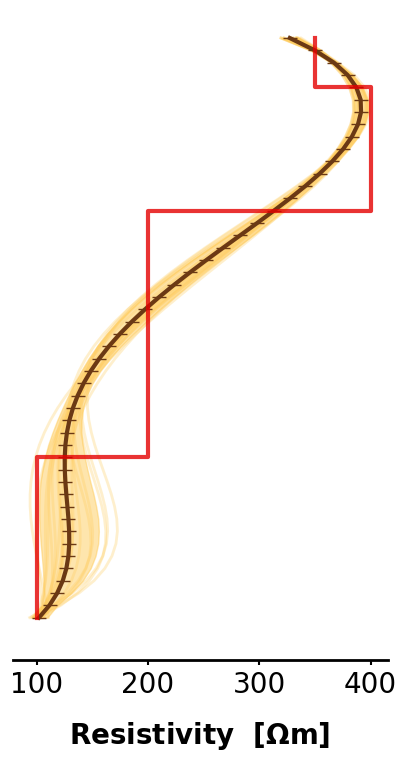

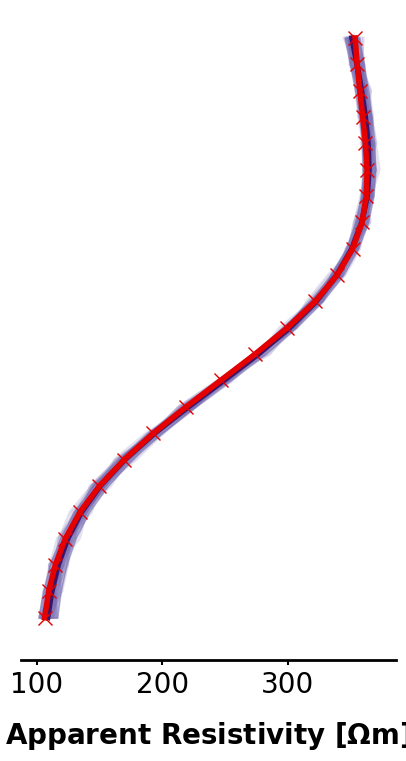

In [37]:
plot_depth_profile_with_ci(
    res_samples=random_post_samples_block,
    gt_res=resistivites_block,
    mean_res=mean_res_block,
    conf_intervals_res=conf_intervals_res_block,
    filename='synth_data/ppc_poly_posterior_on_simulated_data_block_depth.svg',
    step=True,
    mean_step=False,
    yaxis_visible=False
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_block,
    gt_app_res=app_res_block,
    mean_app_res=mean_ar_block,
    conf_intervals_app_res=conf_intervals_ar_block,
    filename='synth_data/ppc_poly_posterior_on_simulated_data_block_app_res.svg',
    yaxis_visible=False
)


In [38]:
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '14pt', 'weight': '800'}
kwargs_text_light = {'size': '10pt', 'weight': '600'}

f = Figure("50cm", "40cm",

           Panel(
               SVG("plots/synth_data/ppc_poly_posterior_on_simulated_data_block_depth.svg").scale(svg_scale),
               Text("c", -20, 50, **kwargs_text)
           ).move(940, 20),

           Panel(
               SVG("plots/synth_data/ppc_poly_posterior_on_simulated_data_block_app_res.svg").scale(svg_scale),
               Text("f", -20, 50, **kwargs_text)
           ).move(940, 720),

           Panel(
               SVG("plots/synth_data/ppc_poly_posterior_on_simulated_data_step_app_res.svg").scale(svg_scale),
               Text("d", -20, 50, **kwargs_text)
           ).move(40, 720),

           Panel(
               SVG("plots/synth_data/ppc_poly_posterior_on_simulated_data_poly_app_res.svg").scale(svg_scale),
               Text("e", -20, 50, **kwargs_text)
           ).move(530, 720),

           Panel(
               SVG("plots/synth_data/ppc_poly_posterior_on_simulated_data_step_depth.svg").scale(svg_scale),
               Text("a", -10, 50, **kwargs_text)
           ).move(40, 20),

           Panel(
               SVG("plots/synth_data/ppc_poly_posterior_on_simulated_data_poly_depth.svg").scale(svg_scale),
               Text("b", -20, 50, **kwargs_text)
           ).move(530, 20),
           )

f.save("plots/figures/fig2/synth_data_poly_posterior.svg")
svg("plots/figures/fig2/synth_data_poly_posterior.svg")

# Validation of Independent Step Model on Synthetic Data

### Validation on Step Example

In [39]:
random_post_samples_ind_step, sim_apparent_resistivities_ind_step, mean_res_ind_step, conf_intervals_res_ind_step, mean_ar_ind_step, conf_intervals_ar_ind_step = compute_cis_and_means_from_ind_step_posterior_sammples(
    app_res_step)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [40]:
print('Avg RMSE parameter space:', avg_rmse(prior_sample_step, random_post_samples_ind_step))
print('Avg RMSE observation space:', avg_rmse(app_res_step, sim_apparent_resistivities_ind_step))

Avg RMSE parameter space: 212.23956
Avg RMSE observation space: 20.539336015963862


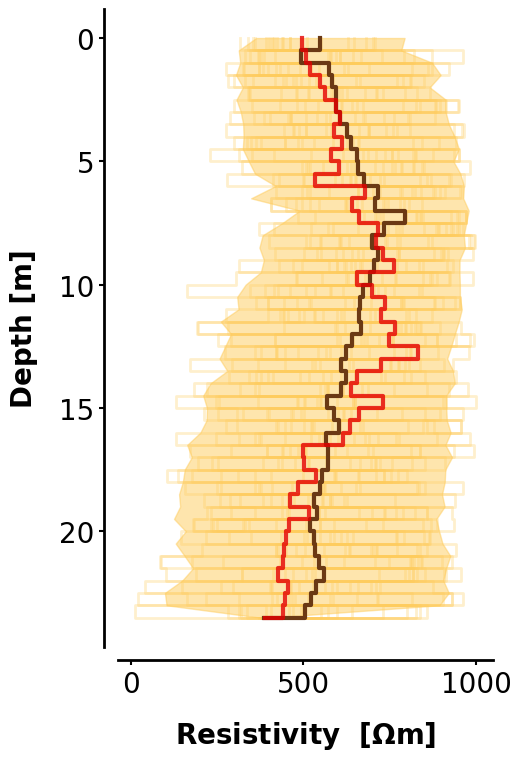

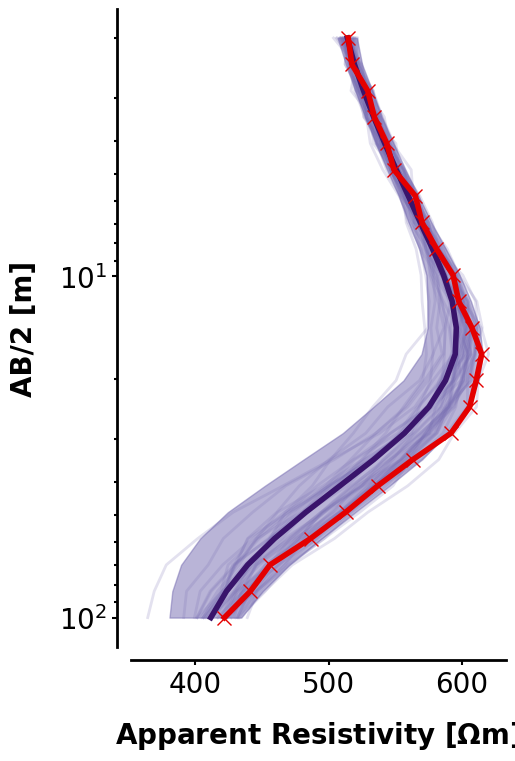

In [41]:
plot_depth_profile_with_ci(
    res_samples=random_post_samples_ind_step,
    gt_res=prior_sample_step,
    mean_res=mean_res_ind_step,
    conf_intervals_res=conf_intervals_res_ind_step,
    filename='synth_data/ppc_ind_step_posterior_on_simulated_data_step_depth.svg',
    step=True,
    mean_step=True,
    yaxis_label=True,
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_ind_step,
    gt_app_res=app_res_step,
    mean_app_res=mean_ar_ind_step,
    conf_intervals_app_res=conf_intervals_ar_ind_step,
    filename='synth_data/ppc_ind_step_posterior_on_simulated_data_step_app_res.svg',
    yaxis_label=True
)


### Validation on Polynomial Example

In [42]:
post_resistivities_poly, sim_apparent_resistivities_poly, mean_res_poly, conf_intervals_res_poly, mean_ar_poly, conf_intervals_ar_poly = compute_cis_and_means_from_ind_step_posterior_sammples(
    app_res_poly)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [43]:
print('Avg RMSE parameter space:', avg_rmse(coefficients_to_resistivity(prior_sample_poly), post_resistivities_poly))
print('Avg RMSE observation space:', avg_rmse(app_res_poly, sim_apparent_resistivities_poly))

Avg RMSE parameter space: 244.686744820074
Avg RMSE observation space: 11.848383192723412


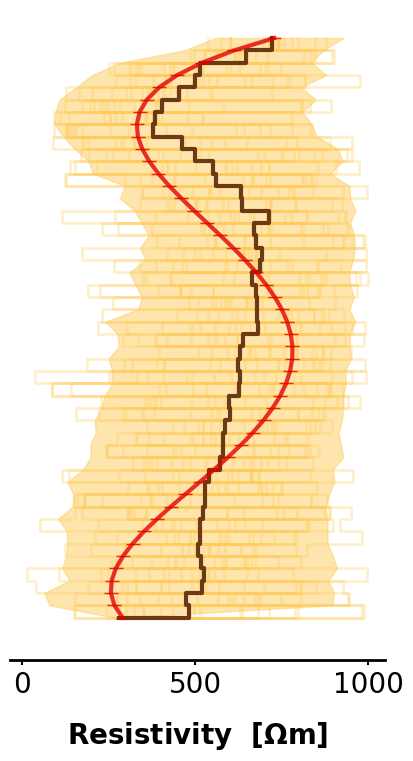

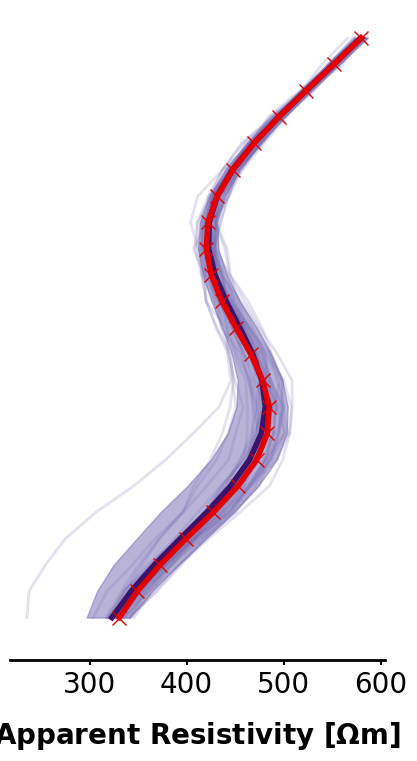

In [44]:
plot_depth_profile_with_ci(
    res_samples=post_resistivities_poly,
    gt_res=coefficients_to_resistivity(prior_sample_poly),
    mean_res=mean_res_poly,
    conf_intervals_res=conf_intervals_res_poly,
    filename='synth_data/ppc_ind_step_posterior_on_simulated_data_poly_depth.svg',
    step=False,
    mean_step=True,
    yaxis_visible=False
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_poly,
    gt_app_res=app_res_poly,
    mean_app_res=mean_ar_poly,
    conf_intervals_app_res=conf_intervals_ar_poly,
    filename='synth_data/ppc_ind_step_posterior_on_simulated_data_poly_app_res.svg',
    legend=False,
    yaxis_visible=False
)


### Validation on Block Example

In [45]:
random_post_samples_block, sim_apparent_resistivities_block, mean_res_block, conf_intervals_res_block, mean_ar_block, conf_intervals_ar_block = compute_cis_and_means_from_ind_step_posterior_sammples(
    app_res_block)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [46]:
print('Avg RMSE parameter space:', avg_rmse(resistivites_block, random_post_samples_block))
print('Avg RMSE observation space:', avg_rmse(app_res_block, sim_apparent_resistivities_block))

Avg RMSE parameter space: 347.78854
Avg RMSE observation space: 54.00518705453037


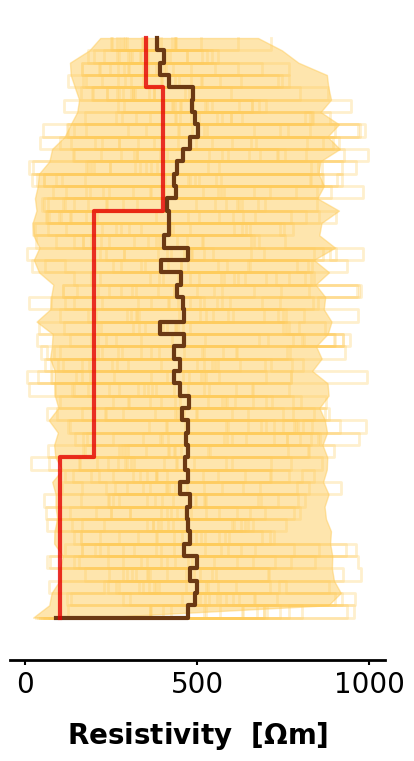

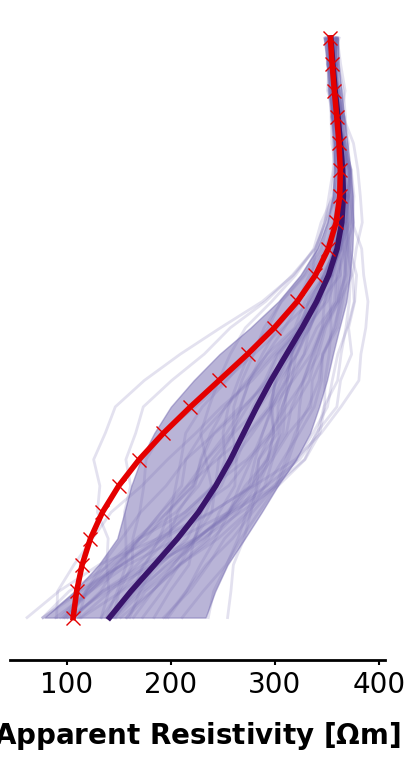

In [47]:
plot_depth_profile_with_ci(
    res_samples=random_post_samples_block,
    gt_res=resistivites_block,
    mean_res=mean_res_block,
    conf_intervals_res=conf_intervals_res_block,
    filename='synth_data/ppc_ind_step_posterior_on_simulated_data_block_depth.svg',
    step=True,
    mean_step=True,
    yaxis_visible=False
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_block,
    gt_app_res=app_res_block,
    mean_app_res=mean_ar_block,
    conf_intervals_app_res=conf_intervals_ar_block,
    filename='synth_data/ppc_ind_step_posterior_on_simulated_data_block_app_res.svg',
    yaxis_label=True,
    yaxis_visible=False
)


### Merge plots into one figure

In [48]:
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '14pt', 'weight': '800'}
kwargs_text_light = {'size': '10pt', 'weight': '600'}

f = Figure("50cm", "40cm",

           Panel(
               SVG("plots/synth_data/ppc_ind_step_posterior_on_simulated_data_block_depth.svg").scale(svg_scale),
               Text("c", -20, 50, **kwargs_text)
           ).move(940, 20),

           Panel(
               SVG("plots/synth_data/ppc_ind_step_posterior_on_simulated_data_block_app_res.svg").scale(svg_scale),
               Text("f", -20, 50, **kwargs_text)
           ).move(940, 720),

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_step_app_res.svg").scale(svg_scale),
               Text("d", -20, 50, **kwargs_text)
           ).move(40, 720),

           Panel(
               SVG("plots/synth_data/ppc_ind_step_posterior_on_simulated_data_poly_app_res.svg").scale(svg_scale),
               Text("e", -20, 50, **kwargs_text)
           ).move(530, 720),

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_step_depth.svg").scale(svg_scale),
               Text("a", -10, 50, **kwargs_text)
           ).move(40, 20),

           Panel(
               SVG("plots/synth_data/ppc_ind_step_posterior_on_simulated_data_poly_depth.svg").scale(svg_scale),
               Text("b", -20, 50, **kwargs_text)
           ).move(530, 20),
           )

f.save("plots/figures/fig3/synth_data_ind_step_posterior.svg")
svg("plots/figures/fig3/synth_data_ind_step_posterior.svg")

# Validation of Block Model on Synthetic Data

### Validation on Step Example

In [49]:
random_post_samples_step, trans_res_samples_step, sim_apparent_resistivities_step, mean_res_step, conf_intervals_res_step, mean_ar_step, conf_intervals_ar_step = compute_cis_and_means_from_block_posterior_sammples(
    app_res_step)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [50]:
# the resolution of block samples is at 0.1m steps so we need to transform s.t. we can compare the results in depth
trans_samples = transform_to_lower_res_samples(trans_res_samples_step)
print('Avg RMSE parameter space:', avg_rmse(prior_sample_step, trans_samples))
print('Avg RMSE observation space:', avg_rmse(app_res_step, sim_apparent_resistivities_step))

Avg RMSE parameter space: 87.94583109507315
Avg RMSE observation space: 6.446971604711754


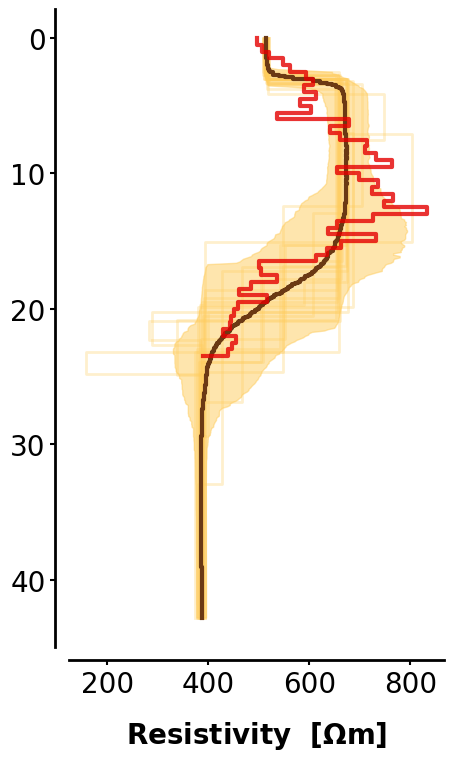

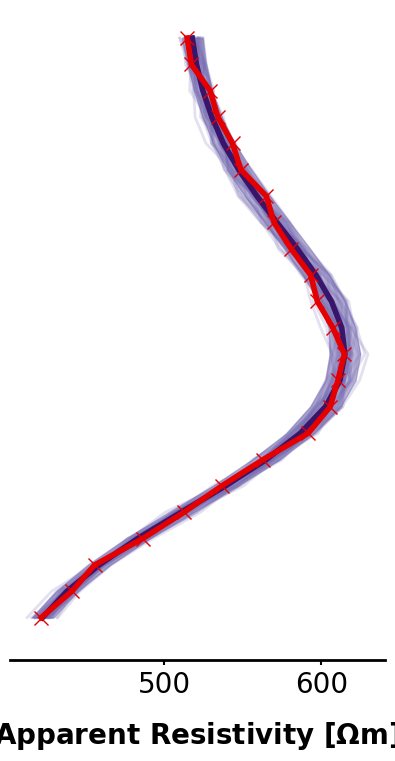

In [51]:
plot_block_depth_results(
    res_samples=trans_res_samples_step,
    gt_res=prior_sample_step,
    mean_res=mean_res_step,
    conf_intervals_res=conf_intervals_res_step,
    filename='synth_data/ppc_block_posterior_on_simulated_data_step_depth.svg',
    step=True,
    mean_step=True,
    yaxis_label=False,
    yaxis_visible=True
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_step,
    gt_app_res=app_res_step,
    mean_app_res=mean_ar_step,
    conf_intervals_app_res=conf_intervals_ar_step,
    filename='synth_data/ppc_block_posterior_on_simulated_data_step_app_res.svg',
    yaxis_label=False,
    yaxis_visible=False
)


### Validation on Polynomial Example

In [52]:
random_post_samples_poly, trans_res_samples_poly, sim_apparent_resistivities_poly, mean_res_poly, conf_intervals_res_poly, mean_ar_poly, conf_intervals_ar_poly = compute_cis_and_means_from_block_posterior_sammples(
    app_res_poly)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [53]:
# the resolution of block samples is at 0.1m steps so we need to transform s.t. we can compare the results in depth
trans_samples = transform_to_lower_res_samples(trans_res_samples_poly)
print('Avg RMSE parameter space:', avg_rmse(coefficients_to_resistivity(prior_sample_poly), trans_samples))
print('Avg RMSE observation space:', avg_rmse(app_res_poly, sim_apparent_resistivities_poly))

Avg RMSE parameter space: 170.17543062669446
Avg RMSE observation space: 16.030854786122386


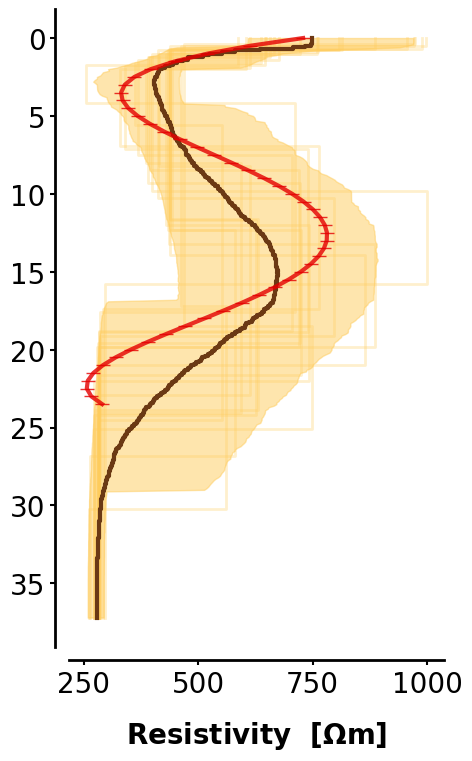

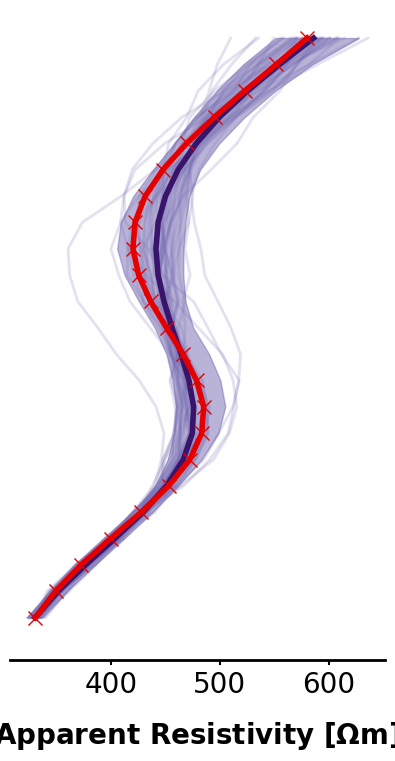

In [54]:
plot_block_depth_results(
    res_samples=trans_res_samples_poly,
    gt_res=coefficients_to_resistivity(prior_sample_poly),
    mean_res=mean_res_poly,
    conf_intervals_res=conf_intervals_res_poly,
    filename='synth_data/ppc_block_posterior_on_simulated_data_poly_depth.svg',
    step=False,
    mean_step=True,
    yaxis_visible=True
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_poly,
    gt_app_res=app_res_poly,
    mean_app_res=mean_ar_poly,
    conf_intervals_app_res=conf_intervals_ar_poly,
    filename='synth_data/ppc_block_posterior_on_simulated_data_poly_app_res.svg',
    yaxis_label=False,
    yaxis_visible=False
)


### Validation on Block Example

In [55]:
random_post_samples_block, trans_res_samples_block, sim_apparent_resistivities_block, mean_res_block, conf_intervals_res_block, mean_ar_block, conf_intervals_ar_block = compute_cis_and_means_from_block_posterior_sammples(
    app_res_block)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [56]:
# the resolution of block samples is at 0.1m steps so we need to transform s.t. we can compare the results in depth
trans_samples = transform_to_lower_res_samples(trans_res_samples_block)
print('Avg RMSE parameter space:', avg_rmse(resistivites_block, trans_samples))
print('Avg RMSE observation space:', avg_rmse(app_res_block, sim_apparent_resistivities_block))

Avg RMSE parameter space: 107.72533561009877
Avg RMSE observation space: 7.048466868443951


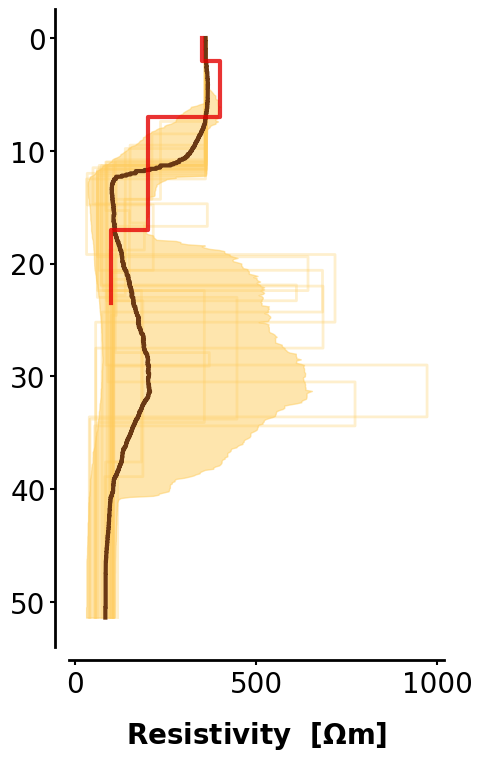

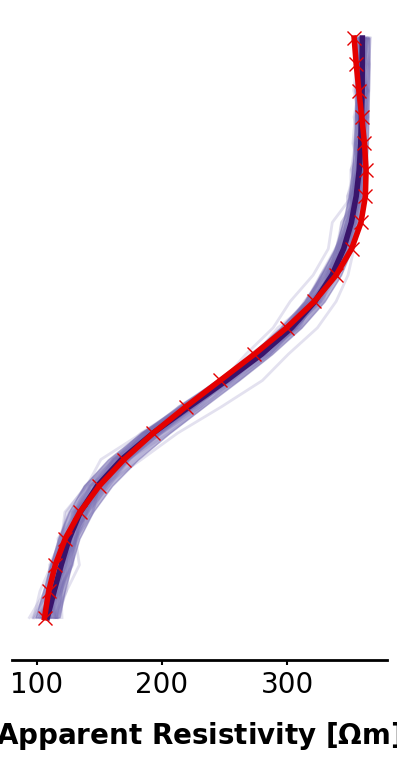

In [57]:
plot_block_depth_results(
    res_samples=trans_res_samples_block,
    gt_res=resistivites_block,
    mean_res=mean_res_block,
    conf_intervals_res=conf_intervals_res_block,
    filename='synth_data/ppc_block_posterior_on_simulated_data_block_depth.svg',
    step=True,
    mean_step=True,
    yaxis_visible=True
)

plot_app_res_with_ci(
    app_res_samples=sim_apparent_resistivities_block,
    gt_app_res=app_res_block,
    mean_app_res=mean_ar_block,
    conf_intervals_app_res=conf_intervals_ar_block,
    filename='synth_data/ppc_block_posterior_on_simulated_data_block_app_res.svg',
    yaxis_label=False,
    yaxis_visible=False
)


### Merge plots into one figure

In [58]:
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '14pt', 'weight': '800'}
kwargs_text_light = {'size': '10pt', 'weight': '600'}

f = Figure("50cm", "40cm",

           Panel(
               SVG("plots/synth_data/ppc_block_posterior_on_simulated_data_block_depth.svg").scale(svg_scale),
               Text("c", -20, 50, **kwargs_text)
           ).move(940, 20),

           Panel(
               SVG("plots/synth_data/ppc_block_posterior_on_simulated_data_block_app_res.svg").scale(svg_scale),
               Text("f", -20, 50, **kwargs_text)
           ).move(940, 720),

           Panel(
               SVG("plots/synth_data/ppc_block_posterior_on_simulated_data_step_app_res.svg").scale(svg_scale),
               Text("d", -20, 50, **kwargs_text)
           ).move(40, 720),

           Panel(
               SVG("plots/synth_data/ppc_block_posterior_on_simulated_data_poly_app_res.svg").scale(svg_scale),
               Text("e", -20, 50, **kwargs_text)
           ).move(530, 720),

           Panel(
               SVG("plots/synth_data/ppc_block_posterior_on_simulated_data_step_depth.svg").scale(svg_scale),
               Text("a", -10, 50, **kwargs_text)
           ).move(40, 20),

           Panel(
               SVG("plots/synth_data/ppc_block_posterior_on_simulated_data_poly_depth.svg").scale(svg_scale),
               Text("b", -20, 50, **kwargs_text)
           ).move(530, 20),
           )

f.save("plots/figures/fig4/synth_data_block_posterior.svg")
svg("plots/figures/fig4/synth_data_block_posterior.svg")

# Pygimli results for GT samples

## Step

In [59]:
model_step_layer4, inv_response_step_layer4 = unpickle_objects('data/inversion/synth/pygimli-inversion-step-layer4.pkl')
inv_res_step_4 = process_gimli_results(model_step_layer4)

model_step_layer5, inv_response_step_layer5 = unpickle_objects('data/inversion/synth/pygimli-inversion-step-layer5.pkl')
inv_res_step_5 = process_gimli_results(model_step_layer5)

model_step_layer48, inv_response_step_layer48 = unpickle_objects(
    'data/inversion/synth/pygimli-inversion-step-layer48.pkl')
inv_res_step_48 = process_gimli_results(model_step_layer48)

In [60]:
# the resolution of block samples is at 0.1m steps so we need to transform s.t. we can compare the results in depth
print('Avg RMSE parameter space 4 layers:', avg_rmse(prior_sample_step, [inv_res_step_4]))
print('Avg RMSE parameter space 5 layers:', avg_rmse(prior_sample_step, [inv_res_step_5]))
print('Avg RMSE parameter space 48 layers:', avg_rmse(prior_sample_step, [inv_res_step_48[:48]]))

Avg RMSE parameter space 4 layers: 91.2485
Avg RMSE parameter space 5 layers: 82.225204
Avg RMSE parameter space 48 layers: 87.31466


In [61]:
# the resolution of block samples is at 0.1m steps so we need to transform s.t. we can compare the results in depth
print('Avg RMSE observation space 4 layers:', avg_rmse(app_res_step, [inv_response_step_layer4]))
print('Avg RMSE observation space 5 layers:', avg_rmse(app_res_step, [inv_response_step_layer5]))
print('Avg RMSE observation space 48 layers:', avg_rmse(app_res_step, [inv_response_step_layer48[:48]]))

Avg RMSE observation space 4 layers: 3.0093138335624556
Avg RMSE observation space 5 layers: 2.7167002438657804
Avg RMSE observation space 48 layers: 4.604668030666417


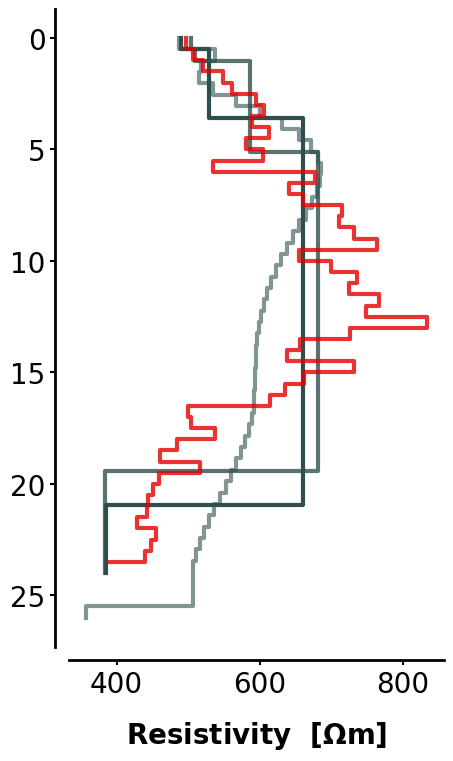

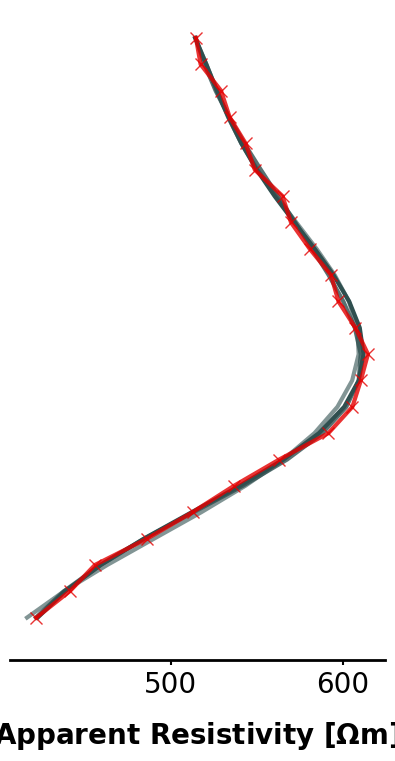

In [62]:
plot_pygimli_depth_results(
    pygimli_res=[(inv_res_step_4, 4), (inv_res_step_5, 5), (inv_res_step_48, 48)],
    gt_res=prior_sample_step,
    filename='synth_data/pygimli/step_gt_depth.svg',
    yaxis_visible=True
)

plot_pygimli_responses(
    gt_app_res=app_res_step,
    pygimli_app_res=[(inv_response_step_layer4, 4), (inv_response_step_layer5, 5), (inv_response_step_layer48, 48)],
    filename='synth_data/pygimli/step_gt_app_res.svg',
    legend=False,
    yaxis_visible=False
)

## Poly

In [63]:
model_poly_layer4, inv_response_poly_layer4 = unpickle_objects('data/inversion/synth/pygimli-inversion-poly-layer4.pkl')
inv_res_poly_4 = process_gimli_results(model_poly_layer4)

model_poly_layer5, inv_response_poly_layer5 = unpickle_objects('data/inversion/synth/pygimli-inversion-poly-layer5.pkl')
inv_res_poly_5 = process_gimli_results(model_poly_layer5)

model_poly_layer48, inv_response_poly_layer48 = unpickle_objects(
    'data/inversion/synth/pygimli-inversion-poly-layer48.pkl')
inv_res_poly_48 = process_gimli_results(model_poly_layer48)

In [64]:
# the resolution of block samples is at 0.1m steps so we need to transform s.t. we can compare the results in depth
print('Avg RMSE parameter space 4 layers:',
      avg_rmse(coefficients_to_resistivity(prior_sample_poly), [inv_res_poly_4[:48]]))
print('Avg RMSE parameter space 5 layers:',
      avg_rmse(coefficients_to_resistivity(prior_sample_poly), [inv_res_poly_5[:48]]))
print('Avg RMSE parameter space 48 layers:',
      avg_rmse(coefficients_to_resistivity(prior_sample_poly), [inv_res_poly_48[:48]]))

Avg RMSE parameter space 4 layers: 167.94600042621508
Avg RMSE parameter space 5 layers: 100.9462829020012
Avg RMSE parameter space 48 layers: 154.75453017699328


In [65]:
# the resolution of block samples is at 0.1m steps so we need to transform s.t. we can compare the results in depth
print('Avg RMSE observation space 4 layers:', avg_rmse(app_res_poly, [inv_response_poly_layer4]))
print('Avg RMSE observation space 5 layers:', avg_rmse(app_res_poly, [inv_response_poly_layer5]))
print('Avg RMSE observation space 48 layers:', avg_rmse(app_res_poly, [inv_response_poly_layer48[:48]]))

Avg RMSE observation space 4 layers: 15.276923766474876
Avg RMSE observation space 5 layers: 0.8270245707764952
Avg RMSE observation space 48 layers: 4.352861738410232


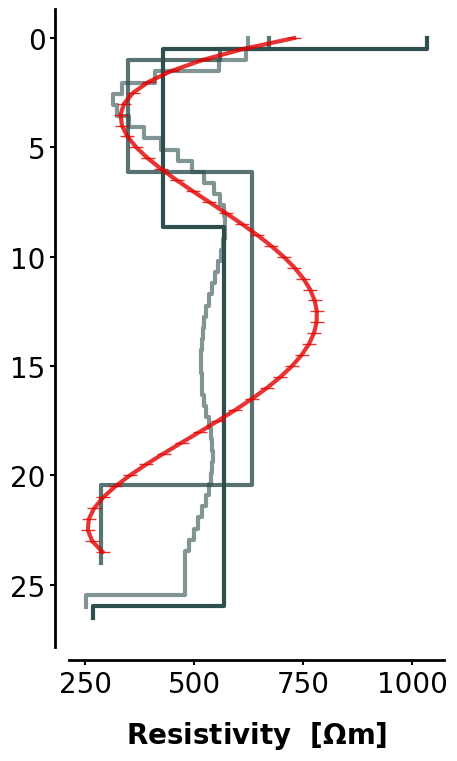

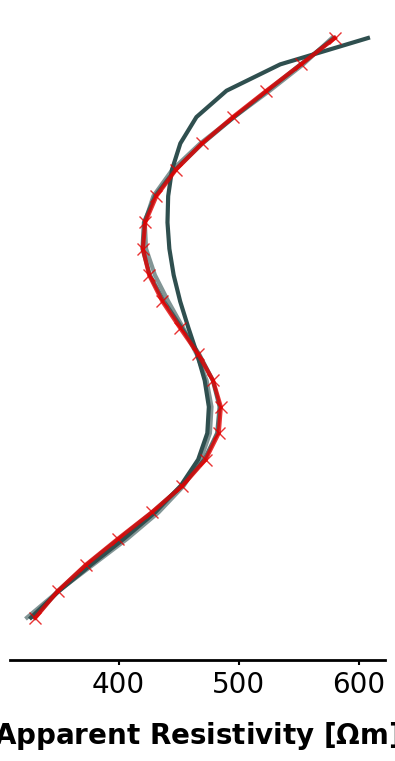

In [66]:
plot_pygimli_depth_results(
    pygimli_res=[(inv_res_poly_4, 4), (inv_res_poly_5, 5), (inv_res_poly_48, 48)],
    gt_res=coefficients_to_resistivity(prior_sample_poly),
    filename='synth_data/pygimli/poly_gt_depth.svg',
    yaxis_visible=True,
    gt_step=False
)

plot_pygimli_responses(
    gt_app_res=app_res_poly,
    pygimli_app_res=[(inv_response_poly_layer4, 4), (inv_response_poly_layer5, 5), (inv_response_poly_layer48, 48)],
    filename='synth_data/pygimli/poly_gt_app_res.svg',
    legend=False,
    yaxis_visible=False
)

## Block

In [67]:
model_block_layer4, inv_response_block_layer4 = unpickle_objects(
    'data/inversion/synth/pygimli-inversion-block-layer4.pkl')
inv_res_block_4 = process_gimli_results(model_block_layer4)

model_block_layer5, inv_response_block_layer5 = unpickle_objects(
    'data/inversion/synth/pygimli-inversion-block-layer5.pkl')
inv_res_block_5 = process_gimli_results(model_block_layer5)

model_block_layer48, inv_response_block_layer48 = unpickle_objects(
    'data/inversion/synth/pygimli-inversion-block-layer48.pkl')
inv_res_block_48 = process_gimli_results(model_block_layer48)

In [68]:
# the resolution of block samples is at 0.1m steps so we need to transform s.t. we can compare the results in depth
print('Avg RMSE parameter space 4 layers:', avg_rmse(resistivites_block, [inv_res_block_4[:48]]))
print('Avg RMSE parameter space 5 layers:', avg_rmse(resistivites_block, [inv_res_block_5[:48]]))
print('Avg RMSE parameter space 48 layers:', avg_rmse(resistivites_block, [inv_res_block_48[:48]]))

Avg RMSE parameter space 4 layers: 58.153416
Avg RMSE parameter space 5 layers: 32.720318
Avg RMSE parameter space 48 layers: 35.576206


In [69]:
# the resolution of block samples is at 0.1m steps so we need to transform s.t. we can compare the results in depth
print('Avg RMSE observation space 4 layers:', avg_rmse(app_res_block, [inv_response_block_layer4]))
print('Avg RMSE observation space 5 layers:', avg_rmse(app_res_block, [inv_response_block_layer5]))
print('Avg RMSE observation space 48 layers:', avg_rmse(app_res_block, [inv_response_block_layer48[:48]]))

Avg RMSE observation space 4 layers: 1.6948496090088028
Avg RMSE observation space 5 layers: 0.879008295814516
Avg RMSE observation space 48 layers: 1.5227597750109805


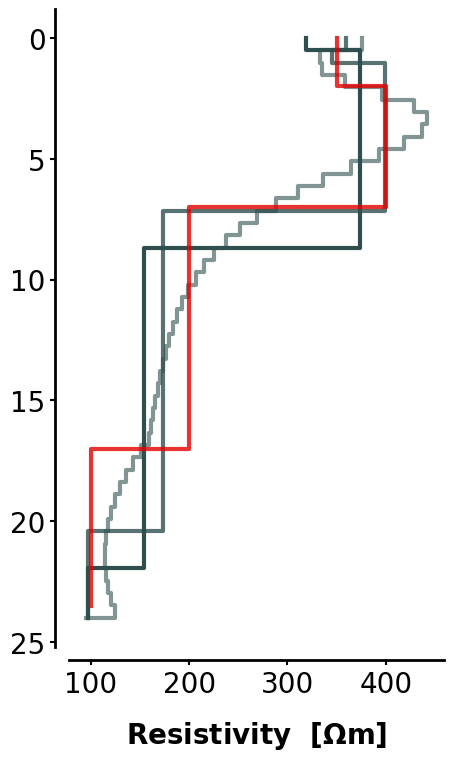

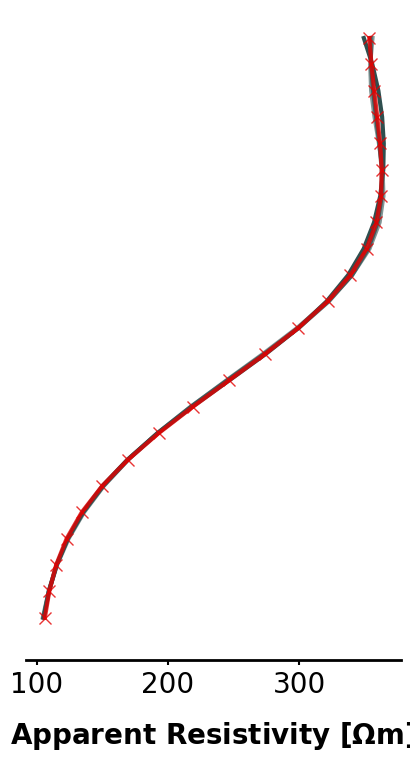

In [70]:
plot_pygimli_depth_results(
    pygimli_res=[(inv_res_block_4, 4), (inv_res_block_5, 5), (inv_res_block_48, 48)],
    gt_res=resistivites_block,
    filename='synth_data/pygimli/block_gt_depth.svg',
    yaxis_visible=True
)

plot_pygimli_responses(
    gt_app_res=app_res_block,
    pygimli_app_res=[(inv_response_block_layer4, 4), (inv_response_block_layer5, 5), (inv_response_block_layer48, 48)],
    filename='synth_data/pygimli/block_gt_app_res.svg',
    legend=False,
    yaxis_visible=False
)

# Merge plots according to GT Sample

### Step GT

In [71]:
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '14pt', 'weight': '800'}
kwargs_text_light = {'size': '10pt', 'weight': '600'}

f = Figure("60cm", "40cm",

           Panel(
               SVG("plots/synth_data/pygimli/step_gt_depth.svg").scale(svg_scale),
               Text("e", -20, 50, **kwargs_text)
           ).move(1800, 20),

           Panel(
               SVG("plots/synth_data/pygimli/step_gt_app_res.svg").scale(svg_scale),
               Text("j", -20, 50, **kwargs_text)
           ).move(1800, 720),

           Panel(
               SVG("plots/synth_data/ppc_block_posterior_on_simulated_data_step_depth.svg").scale(svg_scale),
               Text("d", -20, 50, **kwargs_text)
           ).move(1400, 20),

           Panel(
               SVG("plots/synth_data/ppc_block_posterior_on_simulated_data_step_app_res.svg").scale(svg_scale),
               Text("i", -20, 50, **kwargs_text)
           ).move(1400, 720),

           Panel(
               SVG("plots/synth_data/ppc_ind_step_posterior_on_simulated_data_step_depth.svg").scale(svg_scale),
               Text("c", -20, 50, **kwargs_text)
           ).move(940, 20),

           Panel(
               SVG("plots/synth_data/ppc_ind_step_posterior_on_simulated_data_step_app_res.svg").scale(svg_scale),
               Text("h", -20, 50, **kwargs_text)
           ).move(940, 720),

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_step_app_res.svg").scale(svg_scale),
               Text("f", -20, 50, **kwargs_text)
           ).move(40, 720),

           Panel(
               SVG("plots/synth_data/ppc_poly_posterior_on_simulated_data_step_app_res.svg").scale(svg_scale),
               Text("g", -20, 50, **kwargs_text)
           ).move(530, 720),

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_step_depth.svg").scale(svg_scale),
               Text("a", -10, 50, **kwargs_text)
           ).move(40, 20),

           Panel(
               SVG("plots/synth_data/ppc_poly_posterior_on_simulated_data_step_depth.svg").scale(svg_scale),
               Text("b", -20, 50, **kwargs_text)
           ).move(530, 20),
           )

f.save("plots/figures/fig4/synth_data_gt_step_all_posteriors.svg")
svg("plots/figures/fig4/synth_data_gt_step_all_posteriors.svg")

### Poly GT

In [72]:
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '14pt', 'weight': '800'}
kwargs_text_light = {'size': '10pt', 'weight': '600'}

f = Figure("60cm", "40cm",

           Panel(
               SVG("plots/synth_data/pygimli/poly_gt_depth.svg").scale(svg_scale),
               Text("e", -20, 50, **kwargs_text)
           ).move(1800, 20),

           Panel(
               SVG("plots/synth_data/pygimli/poly_gt_app_res.svg").scale(svg_scale),
               Text("j", -20, 50, **kwargs_text)
           ).move(1800, 720),

           Panel(
               SVG("plots/synth_data/ppc_block_posterior_on_simulated_data_poly_depth.svg").scale(svg_scale),
               Text("d", -20, 50, **kwargs_text)
           ).move(1400, 20),

           Panel(
               SVG("plots/synth_data/ppc_block_posterior_on_simulated_data_poly_app_res.svg").scale(svg_scale),
               Text("i", -20, 50, **kwargs_text)
           ).move(1400, 720),

           Panel(
               SVG("plots/synth_data/ppc_ind_step_posterior_on_simulated_data_poly_depth.svg").scale(svg_scale),
               Text("c", -20, 50, **kwargs_text)
           ).move(940, 20),

           Panel(
               SVG("plots/synth_data/ppc_ind_step_posterior_on_simulated_data_poly_app_res.svg").scale(svg_scale),
               Text("h", -20, 50, **kwargs_text)
           ).move(940, 720),

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_poly_app_res.svg").scale(svg_scale),
               Text("f", -20, 50, **kwargs_text)
           ).move(40, 720),

           Panel(
               SVG("plots/synth_data/ppc_poly_posterior_on_simulated_data_poly_app_res.svg").scale(svg_scale),
               Text("g", -20, 50, **kwargs_text)
           ).move(530, 720),

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_poly_depth.svg").scale(svg_scale),
               Text("a", -10, 50, **kwargs_text)
           ).move(40, 20),

           Panel(
               SVG("plots/synth_data/ppc_poly_posterior_on_simulated_data_poly_depth.svg").scale(svg_scale),
               Text("b", -20, 50, **kwargs_text)
           ).move(530, 20),
           )

f.save("plots/figures/fig5/synth_data_gt_poly_all_posteriors.svg")
svg("plots/figures/fig5/synth_data_gt_poly_all_posteriors.svg")

### Block GT

In [73]:
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '14pt', 'weight': '800'}
kwargs_text_light = {'size': '10pt', 'weight': '600'}

f = Figure("60cm", "40cm",

           Panel(
               SVG("plots/synth_data/pygimli/block_gt_depth.svg").scale(svg_scale),
               Text("e", -20, 50, **kwargs_text)
           ).move(1800, 20),

           Panel(
               SVG("plots/synth_data/pygimli/block_gt_app_res.svg").scale(svg_scale),
               Text("j", -20, 50, **kwargs_text)
           ).move(1800, 720),

           Panel(
               SVG("plots/synth_data/ppc_block_posterior_on_simulated_data_block_depth.svg").scale(svg_scale),
               Text("d", -20, 50, **kwargs_text)
           ).move(1400, 20),

           Panel(
               SVG("plots/synth_data/ppc_block_posterior_on_simulated_data_block_app_res.svg").scale(svg_scale),
               Text("i", -20, 50, **kwargs_text)
           ).move(1400, 720),

           Panel(
               SVG("plots/synth_data/ppc_ind_step_posterior_on_simulated_data_block_depth.svg").scale(svg_scale),
               Text("c", -20, 50, **kwargs_text)
           ).move(940, 20),

           Panel(
               SVG("plots/synth_data/ppc_ind_step_posterior_on_simulated_data_block_app_res.svg").scale(svg_scale),
               Text("h", -20, 50, **kwargs_text)
           ).move(940, 720),

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_block_app_res.svg").scale(svg_scale),
               Text("f", -20, 50, **kwargs_text)
           ).move(40, 720),

           Panel(
               SVG("plots/synth_data/ppc_poly_posterior_on_simulated_data_block_app_res.svg").scale(svg_scale),
               Text("g", -20, 50, **kwargs_text)
           ).move(530, 720),

           Panel(
               SVG("plots/synth_data/ppc_step_posterior_on_simulated_data_block_depth.svg").scale(svg_scale),
               Text("a", -10, 50, **kwargs_text)
           ).move(40, 20),

           Panel(
               SVG("plots/synth_data/ppc_poly_posterior_on_simulated_data_block_depth.svg").scale(svg_scale),
               Text("b", -20, 50, **kwargs_text)
           ).move(530, 20),
           )

f.save("plots/figures/fig6/synth_data_gt_block_all_posteriors.svg")
svg("plots/figures/fig6/synth_data_gt_block_all_posteriors.svg")